In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from copy import deepcopy

from sklearn.preprocessing import MinMaxScaler

In [ ]:
device= 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
scaler= MinMaxScaler(feature_range= (-1, 1))

In [ ]:
# download the last 5 years data of input stock symbol
def fetch_data(symbol, frames):
    data= yf.Ticker(symbol+'.NS').history(period= '5y').Close.to_frame()
    data.columns= [column.lower() for column in data.columns]
    data.index= data.index.date.astype('datetime64')

    for frame in range(1, frames+1):
        data[f'shift ({frame})']= data.close.shift(frame)

    data.dropna(inplace=True)
    data= data[data.columns[::-1]]
    data= data.apply(lambda x: x.astype('float32'))

    scaled_data= scaler.fit_transform(data)

    result= pd.DataFrame(data= scaled_data, columns= data.columns, index= data.index)

    return result

In [ ]:
# convert the data into tensor and fetch date, features and label separately
def fetch_tensor(symbol, frames):
    dataframe= fetch_data(symbol, frames)
    x= dataframe.iloc[:, :-1].values
    y= dataframe.iloc[:, -1].values
    x= x.reshape((len(y), x.shape[1], 1))

    return x, y

In [ ]:
# split the tensor into train, validation and test
def split_tensor(symbol, frames):
    x, y= fetch_tensor(symbol, frames)

    split_factor_2= int(len(y)*0.95)

    x_train, y_train= x[:split_factor_2], y[:split_factor_2]
    x_test, y_test= x[split_factor_2:], y[split_factor_2:]

    x_train= x_train.reshape((-1, frames, 1))
    y_train= y_train.reshape((-1, 1))
    x_test= x_test.reshape((-1, frames, 1))
    y_test= y_test.reshape((-1, 1))

    x_train= torch.tensor(x_train).float()
    y_train= torch.tensor(y_train).float()
    x_test= torch.tensor(x_test).float()
    y_test= torch.tensor(y_test).float()

    return x_train, y_train, x_test, y_test

In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, x, y):
    self.x= x
    self.y= y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [ ]:
def fetch_dataset(symbol, frames):
  x_train, y_train, x_test, y_test= split_tensor(symbol, frames)
  train_dataset= TimeSeriesDataset(x_train, y_train)
  test_dataset= TimeSeriesDataset(x_test, y_test)

  return train_dataset, test_dataset

In [ ]:
def fetch_data_loader(symbol, frames, batch_size):
  train_dataset, test_dataset= fetch_dataset(symbol, frames)
  train_loader= DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
  test_loader= DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

  return train_loader, test_loader

In [ ]:
def fetch_data_batches(symbol, frames, batch_size):
  train_loader, test_loader= fetch_data_loader(symbol, frames, batch_size)
  for _, batch in enumerate(train_loader):
    x_batch, y_batch= batch[0].to(device), batch[1].to(device)

    return x_batch, y_batch

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size= hidden_size
    self.num_stacked_layers= num_stacked_layers

    self.lstm= nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first= True)
    self.fc= nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size= x.size(0)
    h0= torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0= torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out= self.fc(out[:, -1, :])
    return out

In [ ]:
model= LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch(symbol, frames, batch_size):
  model.train(True)
  print(f'Epoch: {epoch+1}')
  running_loss= 0.0

  train_loader, test_loader= fetch_data_loader(symbol, frames, batch_size)

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch= batch[0].to(device), batch[1].to(device)

    output= model(x_batch)
    loss= loss_function(output, y_batch)
    running_loss+= loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100== 99:
      avg_loss_across_batches= running_loss/100
      print(f'Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')

      running_loss= 0.0
  print()

In [ ]:
def validate_one_epoch(symbol, frames, batch_size):
  model.train(False)
  running_loss= 0.0

  train_loader, test_loader= fetch_data_loader(symbol, frames, batch_size)

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch= batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output= model(x_batch)
      loss= loss_function(output, y_batch)
      running_loss += loss

    avg_loss_across_batches= running_loss/len(test_loader)

    print(f'Val Loss: {avg_loss_across_batches:.3f}')
    print('***************')
    print()

In [ ]:
symbol= 'ITC'
frames= 5
batch_size= 16

learning_rate= 0.001
num_epochs= 10
loss_function= nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)

for epoch in range(num_epochs):
  train_one_epoch(symbol, frames, batch_size)
  validate_one_epoch(symbol, frames, batch_size)

In [ ]:
x_train, y_train, x_test, y_test= split_tensor(symbol, frames)

with torch.no_grad():
  predicted= model(x_train.to(device)).to('cpu').numpy()

In [ ]:
test_predictions= model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies= np.zeros((x_test.shape[0], frames+1))
dummies[:, 0]= test_predictions
dummies= scaler.inverse_transform(dummies)

test_predictions= deepcopy(dummies[:, 0])
test_predictions

array([445.42669921, 448.57315196, 455.65793169, 460.5607827 ,
       466.72970302, 469.39053984, 468.1965687 , 466.18169992,
       468.1441775 , 468.90591036, 469.17586748, 469.74077167,
       469.79399586, 469.79610027, 472.43332818, 479.15544687,
       482.33394812, 476.47908998, 468.80200481, 468.65044301,
       465.69924062, 465.66381628, 464.81869594, 463.95121618,
       461.35603276, 458.15762724, 455.97979774, 454.92958452,
       453.26526543, 455.46423773, 453.4456643 , 450.88294588,
       449.85488383, 449.88887234, 445.32011931, 443.44186221,
       445.73374667, 450.01305481, 450.28160899, 450.60707009,
       447.02494841, 444.1418984 , 442.09339185, 442.5604955 ,
       441.25248035, 441.38188002, 439.64678897, 441.71561629,
       444.90849772, 445.64476933, 444.31749658, 445.95415137,
       448.65686826, 451.06394758, 450.53345937, 449.4326744 ,
       450.6345371 , 451.6527895 , 449.49806474, 446.23385238,
       444.39131555, 443.43045233])

In [ ]:
dummies= np.zeros((x_test.shape[0], frames+1))
dummies[:, 0]= y_test.flatten()
dummies= scaler.inverse_transform(dummies)

inverse_scaled_y_test= deepcopy(dummies[:, 0])
inverse_scaled_y_test

array([451.60001469, 463.25001817, 466.3499984 , 475.09998502,
       473.89998561, 468.40000654, 465.85002422, 473.14998049,
       472.29997177, 472.0000048 , 472.8999934 , 472.34999549,
       472.49997898, 478.85001061, 492.15000781, 490.44999036,
       471.35000328, 462.30000585, 472.24999189, 465.04999538,
       468.45003027, 465.69999689, 464.80000829, 460.10001422,
       456.04997783, 454.95002586, 454.90000213, 452.35001981,
       458.64998387, 451.74999818, 448.75002156, 449.20001586,
       450.24998795, 440.9999833 , 441.64998481, 447.80000923,
       454.25000062, 450.44999516, 450.89998946, 443.35000226,
       441.39999772, 440.0999947 , 442.80000435, 439.70002412,
       441.05000703, 437.49998865, 443.10001516, 447.45001853,
       445.89998458, 442.64997702, 447.20003144, 451.14997655,
       453.4999955 , 449.95002097, 448.35000714, 452.050009  ,
       452.9499976 , 447.49999842, 443.10001516, 442.59999714,
       442.45001365, 449.14999213])

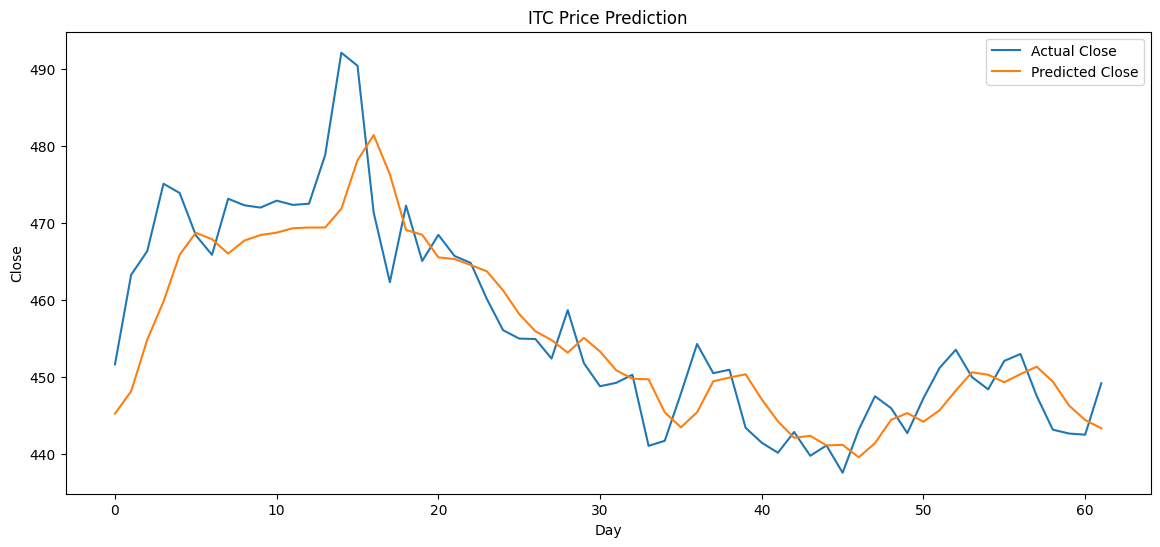

In [ ]:
plt.figure(figsize= (14,6))
plt.plot(inverse_scaled_y_test, label= 'Actual Close')
plt.plot(test_predictions, label= 'Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title(f'{symbol} Price Prediction')
plt.legend()
plt.show()